# Déployez un modèle dans le cloud

- **Projet 8 du parcours « Data Scientist » d’OpenClassrooms**
- **Mark Creasey**


In [1]:
import sagemaker_pyspark

## Import des bibliothèques

In [2]:
import sagemaker # session
import sagemaker_pyspark
import pyspark # spark
import boto3 # S3 bucket
import os

from pyspark import SparkContext, SparkConf
from pyspark.sql import DataFrame, SparkSession
from typing import List
import pyspark.sql.types as T
import pyspark.sql.functions as F

from PIL import Image
import numpy as np
import tensorflow as tf # model

In [3]:
from platform import python_version

print(f'python version = {python_version()}')
print('versions des bibliothèques utilisées:')
print('; '.join(f'{m.__name__}=={m.__version__}' for m in globals(
).values() if getattr(m, '__version__', None)))

python version = 3.8.12
versions des bibliothèques utilisées:
sagemaker==2.92.1; pyspark==3.0.0; boto3==1.23.10; PIL.Image==9.0.1; numpy==1.20.3; tensorflow==2.7.1


## Configuration

In [4]:
S3_BUCKET='mc-oc-8'
DATA_FOLDER='data/train'
OUT_FOLDER='output'

### Create the SparkSession with the SageMaker Spark dependencies.

Examples:
- <https://github.com/aws/amazon-sagemaker-examples/blob/main/sagemaker-spark/pyspark_mnist/pyspark_mnist_xgboost.ipynb>

In [5]:

sess = sagemaker.Session()
aws_role = sagemaker.get_execution_role()
aws_region = boto3.Session().region_name
print(f'aws_region     : {aws_region}')
print(f'region         : {sess.boto_region_name}')
print(f'account_id     : {sess.account_id()}')
print(f'default_bucket : {sess.default_bucket()}')
print(f'aws_role : {aws_role}')

aws_region     : eu-west-3
region         : eu-west-3
account_id     : 125534713363
default_bucket : sagemaker-eu-west-3-125534713363
aws_role : arn:aws:iam::125534713363:role/service-role/AmazonSageMaker-ExecutionRole-20220707T161932


## Credentials used by sagemaker to access S3

In [6]:
credentials =boto3.Session().get_credentials()
keys=['access_key','method','secret_key','token']
for key in keys:
    print(f'key "{key}" : {getattr(credentials,key)[4:8]}')

key "access_key" : R2OT
key "method" : role
key "secret_key" : OIvJ
key "token" : b3Jp


Note: AmazonSageMakerFullAccess role has access to configured S3 buckets - credentials not required

In [7]:
# Configure Spark to use the SageMaker Spark dependency jars
from pyspark import SparkConf
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())
conf = SparkConf().set("spark.driver.extraClassPath",classpath)

# See the SageMaker Spark Github repo under sagemaker-pyspark-sdk
# to learn how to connect to a remote EMR cluster running Spark from a Notebook Instance.
spark = (
    SparkSession.builder
    .config(conf=conf)
    .master("local[*]")
    .appName("Fruit Image Classification")
    .getOrCreate()
)

spark

22/07/08 11:29:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


### Create images

On copie les images vers data

In [8]:
if not os.path.exists(DATA_FOLDER): os.makedirs(DATA_FOLDER)

In [9]:
import io

from PIL import Image  # https://pillow.readthedocs.io/en/4.3.x/
import requests  # http://docs.python-requests.org/en/master/


# example image url: https://github.com/Horea94/Fruit-Images-Dataset/tree/master/Training/
def download_image(url, image_file_path):
    # https://gist.github.com/mjdietzx/545fa2874b2688e9bcb71e2ee92cd5a0
    r = requests.get(url, timeout=4.0)
    if r.status_code != requests.codes.ok:
        assert False, 'Status code error: {}.'.format(r.status_code)

    with Image.open(io.BytesIO(r.content)) as im:
        im.save(image_file_path)

    # print(f'Image downloaded from url: {url} and saved to: {image_file_path}')


# test
url='https://raw.githubusercontent.com/Horea94/Fruit-Images-Dataset/master/Training/Raspberry/0_100.jpg'
if not os.path.exists(f'{DATA_FOLDER}/raspberry.jpg'):
    download_image(url,f'{DATA_FOLDER}/raspberry.jpg')

## Preview an image

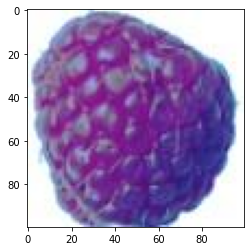

In [10]:
import matplotlib.pyplot as plt
img=Image.open(f'{DATA_FOLDER}/raspberry.jpg')
plt.imshow(img, cmap='gray')

## Transfer images to Bucket

In [11]:
def upload_s3(file_name, object_name=None, s3_bucket=S3_BUCKET):
    if object_name is None:
      object_name=file_name
    s3 = boto3.client('s3')
    with open(file_name, "rb") as f:
        s3.upload_fileobj(f, s3_bucket, object_name)

upload_s3(f'{DATA_FOLDER}/raspberry.jpg')

In [12]:
SRC= 'https://raw.githubusercontent.com/Horea94/Fruit-Images-Dataset/master/Training'
DEST = DATA_FOLDER


FRUITS=['Blueberry','Kiwi','Orange','Pineapple','Raspberry']
ANGLES= range(0,360,60)

def makedirs(path):
    if not os.path.exists(path):
        os.makedirs(path)

def copy_images(bucket=S3_BUCKET):
    for fruit in FRUITS:
        src_path = f'{SRC}/{fruit}/'
        dest_path = f'{DEST}/{fruit}'
        makedirs(dest_path)
        for angle in ANGLES:
            filename =f'{angle}_100.jpg'
            try:
                if not os.path.exists(f'{dest_path}/{filename}'):
                    download_image(f'{src_path}/{filename}',f'{dest_path}/{filename}')
                upload_s3(f'{dest_path}/{filename}',s3_bucket=bucket)
            except:
                # usually because image doesn't exist 
                continue

# if not os.path.exists(f'{DEST}/{FRUITS[-1]}'):
# default_bucket= sess.default_bucket()
# copy_images(default_bucket)
# copy_images(S3_BUCKET)


In [13]:
!aws s3 ls s3://mc-oc-8/data/train/Orange --recursive --human-readable --summarize

2022-07-07 23:22:47    2.5 KiB data/train/Orange/0_100.jpg
2022-07-07 23:22:48    2.5 KiB data/train/Orange/120_100.jpg
2022-07-07 23:22:48    2.6 KiB data/train/Orange/180_100.jpg
2022-07-07 23:22:48    2.5 KiB data/train/Orange/240_100.jpg
2022-07-07 23:22:49    2.5 KiB data/train/Orange/300_100.jpg

Total Objects: 5
   Total Size: 12.6 KiB


In [14]:
s3 = boto3.resource('s3')
bucket=s3.Bucket(S3_BUCKET)
file_iterator= bucket.objects.filter(Prefix=DATA_FOLDER)
for f in file_iterator.limit(8):
    label=f.key.split('/')[-2:-1]
    print(f'label : {label}, {f.key}')

label : ['Blueberry'], data/train/Blueberry/0_100.jpg
label : ['Blueberry'], data/train/Blueberry/120_100.jpg
label : ['Blueberry'], data/train/Blueberry/180_100.jpg
label : ['Blueberry'], data/train/Blueberry/300_100.jpg
label : ['Blueberry'], data/train/Blueberry/60_100.jpg
label : ['Kiwi'], data/train/Kiwi/0_100.jpg
label : ['Kiwi'], data/train/Kiwi/120_100.jpg
label : ['Kiwi'], data/train/Kiwi/180_100.jpg


In [15]:
filelist=[]
for file in file_iterator:
    filelist.append(file.key)

### Create a Resilient Distributed Dataset (RDD)
A RDD is a fault-tolerant collection of elements that can be operated on in parallel. 

There are two ways to create RDDs: 
1. parallelizing an existing collection 
2. referencing a dataset in an external storage system, such as a shared filesystem, HDFS, HBase...

reference: <https://spark.apache.org/docs/latest/rdd-programming-guide.html>

In [16]:
sc= spark.sparkContext
filelist_rdd = sc.parallelize(filelist, numSlices=4)
print (type(filelist_rdd))
print(filelist_rdd.getNumPartitions())

<class 'pyspark.rdd.RDD'>
4


recover original data

In [17]:
filelist_collect= filelist_rdd.collect()
print (type(filelist_collect))
filelist_collect[:3]

<class 'list'>


['data/train/Blueberry/0_100.jpg',
 'data/train/Blueberry/120_100.jpg',
 'data/train/Blueberry/180_100.jpg']

## Create a pyspark DataFrame

In [18]:
from pyspark.sql import Row
filelist_df = filelist_rdd.map(lambda x:Row(x)).toDF(['path'])
print(type(filelist_df))
filelist_df.printSchema()

<class 'pyspark.sql.dataframe.DataFrame'>
root
 |-- path: string (nullable = true)



In [19]:
filelist_df.limit(7).show(truncate=False)

+--------------------------------+
|path                            |
+--------------------------------+
|data/train/Blueberry/0_100.jpg  |
|data/train/Blueberry/120_100.jpg|
|data/train/Blueberry/180_100.jpg|
|data/train/Blueberry/300_100.jpg|
|data/train/Blueberry/60_100.jpg |
|data/train/Kiwi/0_100.jpg       |
|data/train/Kiwi/120_100.jpg     |
+--------------------------------+



### Create label column

In [23]:
df_images = (filelist_df.withColumn('label',F.element_at(F.split(filelist_df['path'],"/"),-2)))

df_images.show(2,False)

+--------------------------------+---------+
|path                            |label    |
+--------------------------------+---------+
|data/train/Blueberry/0_100.jpg  |Blueberry|
|data/train/Blueberry/120_100.jpg|Blueberry|
+--------------------------------+---------+
only showing top 2 rows



## Read image files from S3 bucket into Spark DataFrame

### read image via requests (boto)


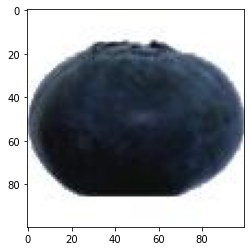

In [20]:
def read_img(object_key):
    """Lire une image de S3,et convertir en image_bytes"""
    # obj = s3.Object(S3_BUCKET, object_key)
    s3 = boto3.resource('s3')
    bucket = s3.Bucket(S3_BUCKET)
    img_obj = io.BytesIO(bucket.Object(object_key).get().get('Body').read())
    img=Image.open(img_obj)
    plt.imshow(img, cmap='gray')

path='s3://mc-oc-8/data/train/Blueberry/180_100.jpg'
object_key= 'data/train/Blueberry/180_100.jpg'
read_img (object_key)

### read image via s3 filesystem

['mc-oc-8/data/train/Blueberry', 'mc-oc-8/data/train/Kiwi', 'mc-oc-8/data/train/Orange', 'mc-oc-8/data/train/Pineapple', 'mc-oc-8/data/train/Raspberry', 'mc-oc-8/data/train/raspberry.jpg']


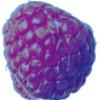

In [21]:


from PIL import Image
import s3fs

fs = s3fs.S3FileSystem()

# To List 5 files in your accessible bucket
print(fs.ls(f's3://{S3_BUCKET}/{DATA_FOLDER}',recursive=True))

image_path=f's3://{S3_BUCKET}/{DATA_FOLDER}/raspberry.jpg'
# open it directly
with fs.open(image_path) as f:
    display(Image.open(f))

### Spark natively reads from S3 using Hadoop APIs

In [22]:
#from pyspark.sql import SQLContext
import io

import boto3

region = boto3.Session().region_name
image_path2=f's3://{default_bucket}/{DATA_FOLDER}/raspberry.jpg'
#sc= spark.sparkContext
#sqlContext=SQLContext(sc)
# df=spark.read.format("image").load(image_path2)

# Error:
# Py4JJavaError: An error occurred while calling o37.load.
#: java.util.ServiceConfigurationError: org.apache.spark.sql.sources.DataSourceRegister: 
# Provider com.amazonaws.services.sagemaker.sparksdk.protobuf.SageMakerProtobufFileFormat 
# could not be instantiated



NameError: name 'default_bucket' is not defined

In [ ]:
S3_BUCKET='mc-oc-8'
DATA_FOLDER='data/train'
data_train_path= f's3a://{S3_BUCKET}/{DATA_FOLDER}'
# df_train = spark.read.format('binaryFile').option('recursiveFileLookup', True).load(data_train_path, inferschema=True)
#df_train.count() 

## List files as a dataframe